In [1]:
# jupyter lab --port=44000 --ip=$HOSTNAME --no-browser

In [1]:
%load_ext autoreload
%autoreload 2
%env MUJOCO_GL=egl
!echo $CUDA_VISIBLE_DEVICES
!echo $HOSTNAME
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

np.set_printoptions(precision=3, suppress=True, linewidth=100)

env: MUJOCO_GL=egl
0
n-62-20-1


In [14]:
import os
jobID = os.getenv('LSB_JOBID')
host = os.getenv('HOSTNAME')
save_name = f"{host}_{jobID}.onnx"
save_name

'n-62-12-19_16901233.onnx'

## 采样抛物线数据

""

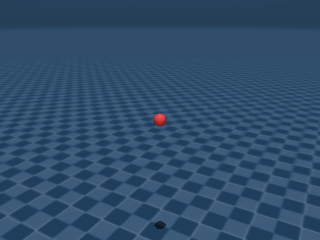

In [4]:
xml = """
<mujoco model="parabolic_target">
  <compiler angle="radian" autolimits="true"/>
  <option integrator="implicit" impratio="10"/>
  <statistic extent="1.5" center="-0.9 0 1"/>
  <visual>
    <headlight diffuse="0.6 0.6 0.6"  ambient="0.3 0.3 0.3" specular="0 0 0"/>
    <rgba haze="0.15 0.25 0.35 1"/>
    <global azimuth="120" elevation="-20"/>
  </visual>
  <default>
    <default class="target">
      <geom rgba=".5 .5 .5 .4"/>
    </default>
  </default>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512"
        height="3072"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4"
        rgb2="0.1 0.2 0.3" markrgb="0.8 0.8 0.8" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5"
        reflectance="0.2"/>
  </asset>
  <worldbody>
    <camera name="target" pos="-2.175 -1.007 1.015" xyaxes="0.377 -0.926 0.000 0.208 0.084 0.975"/>
    <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
    <geom name="floor" size="0 0 0.05" type="plane" material="groundplane"/>
    <body name="reference" pos="-0.9 0 1.0">
      <geom type="sphere" size=".05 .05 .05" rgba="1 0 0 .5"/>
      <site type="sphere" size=".05 .05 .05" name="reference_site"/>
    </body>
    <body name="target" pos="-0.9 0 1.0">
      <geom type="sphere" size=".05 .05 .05" class="target"/>
      <freejoint name="target"/>
      <site type="sphere" size=".05 .05 .05" name="target_site"/>
    </body>
  </worldbody>
  <sensor>
    <touch name="hit" site="target_site"/>
  </sensor>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

0.0
0.002


""

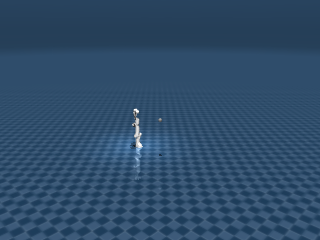

In [2]:
path = r"env/xml/scene_parabola_position.xml"
model = mujoco.MjModel.from_xml_path(path)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)
print(data.time)
mujoco.mj_step(model, data)
print(data.time)
renderer.update_scene(data, camera="parabola")
media.show_image(renderer.render())

In [6]:
def init_controller(model, data, 
                    theta=np.pi/8, v=5):
    jID = f'target'
    x0, y0, z0 = -0.9, 0, 1.0
    vx, vy, vz = 0.0, v*np.cos(theta), v*np.sin(theta)
    data.joint(jID).qpos = np.array([x0, y0, z0, 1, 0, 0, 0])
    data.joint(jID).qvel = np.array([vx, vy, vz, 0, 0.1, 0.1])

In [7]:
duration = 2    # (seconds)
framerate = 60  # (Hz)
frames = []
distances = []
heights = []
y_vels = []
z_vels = []
timevals = []
forces = []
model = mujoco.MjModel.from_xml_path(path)
renderer = mujoco.Renderer(model, height=480, width=640)
data = mujoco.MjData(model)
mujoco.mj_resetDataKeyframe(model, data, 0)
init_controller(model, data, theta=np.pi/6, v=8)
while data.time < duration:
    mujoco.mj_step(model, data)
    distances.append(data.joint("target").qpos[1])
    heights.append(data.joint("target").qpos[2])
    y_vels.append(data.joint("target").qvel[1])
    z_vels.append(data.joint("target").qvel[2])
    forces.append(data.sensordata[0])
    timevals.append(data.time)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, "far")
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

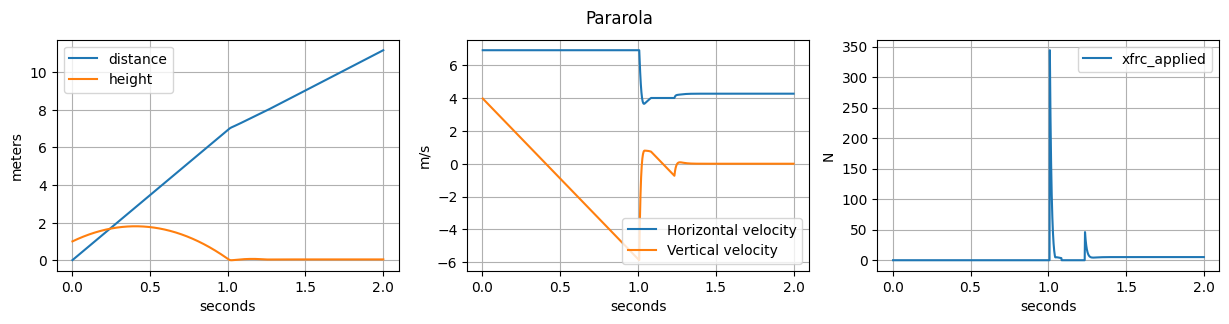

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15,3))
plt.suptitle('Pararola')

ax[0].plot(timevals, distances, label='distance')
ax[0].plot(timevals, heights, label='height')
ax[0].set_ylabel('meters')
ax[0].set_xlabel('seconds')
ax[0].legend()
ax[0].grid()

ax[1].plot(timevals, y_vels, label='Horizontal velocity')
ax[1].plot(timevals, z_vels, label='Vertical velocity')
ax[1].set_ylabel('m/s')
ax[1].set_xlabel('seconds')
ax[1].legend()
ax[1].grid()

ax[2].plot(timevals, forces, label='xfrc_applied')
ax[2].set_ylabel('N')
ax[2].set_xlabel('seconds')
ax[2].legend()
ax[2].grid()

In [14]:
xs = [-0.9,]*len(timevals)
ys = [-i for i in distances]
zs = heights

mocap_data = np.vstack([timevals,
                        [-0.9,]*len(timevals),
                        [-i for i in distances],
                        heights,
                        [0,]*len(timevals),
                        y_vels,
                        [-i for i in z_vels]]).T[-501::-1, :]

# save mocap data as npy file
np.save('env/xml/target_mocap.npy', mocap_data)
mocap_data.shape, mocap_data[:5]

((500, 7),
 array([[ 1.   , -0.9  , -6.928,  0.085,  0.   ,  6.928,  5.81 ],
        [ 0.998, -0.9  , -6.914,  0.097,  0.   ,  6.928,  5.79 ],
        [ 0.996, -0.9  , -6.9  ,  0.108,  0.   ,  6.928,  5.771],
        [ 0.994, -0.9  , -6.887,  0.12 ,  0.   ,  6.928,  5.751],
        [ 0.992, -0.9  , -6.873,  0.131,  0.   ,  6.928,  5.732]]))

## 模拟抛物线，初始点伪随机

In [2]:
def controller(model, data):
    xfrc_applied = data.sensordata[0]
    if xfrc_applied > 1:
        model.geom('target').rgba = [1, 0, 0, 0.5]


def reset(model, data):
    model.geom('target').rgba = [0.5, 0.5, 0.5, 0.4]
    mocap_data = np.load('env/xml/target_mocap.npy')[:500]
    mujoco.mj_resetDataKeyframe(model, data, 0)
    mujoco.set_mjcb_control(controller)
    jID = f'target'
    random_idx = np.random.randint(0, len(mocap_data)-150)
    time = mocap_data[random_idx][0]
    qpos = mocap_data[random_idx][1:4]
    qvel = mocap_data[random_idx][4:]
    data.joint(jID).qpos = np.array([*qpos, 1, 0, 0, 0])
    data.joint(jID).qvel = np.array([*qvel, 0, 0.1, 0.1])
    print(f"设置初始位置为:\ntime={time}\nqpos={qpos}\nqvel={qvel}\nMotion capture data: {len(mocap_data)}")

duration = 2    # (seconds)
framerate = 60  # (Hz)
frames = []
path = r"env/xml/scene_parabola_position.xml"
model = mujoco.MjModel.from_xml_path(path)
data = mujoco.MjData(model)
reset(model, data)
renderer = mujoco.Renderer(model, height=400, width=600)

while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, "close")
        cam0 = renderer.render()
        renderer.update_scene(data, "far")
        cam1 = renderer.render()
        frames.append(np.hstack((cam0, cam1)))
media.show_video(frames, fps=framerate)

设置初始位置为:
time=0.4000000000000003
qpos=[-0.9   -2.771  1.811]
qvel=[ 0.     6.928 -0.076]
Motion capture data: 500


### 给抛物体增加尾迹处理

In [3]:
def get_target_speed(model, data):
    vel = data.joint("target").qvel[:3]
    return np.linalg.norm(vel)

def get_target_height(model, data):
    return data.joint("target").qpos[2]

def add_visual_capsule(scene, point1, point2, radius, rgba):
    if scene.ngeom >= scene.maxgeom:
        raise ValueError("maxgeom exceeded")
    scene.ngeom += 1
    # Args: geom, type, pos, size, rot, rgba
    mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                        mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                        np.zeros(3), np.zeros(9), rgba.astype(np.float32))
    # Args: geom, type, width, a0, a1, a2, b0, b1, b2
    mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                             mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                             point1[0], point1[1], point1[2],
                             point2[0], point2[1], point2[2])   

 # traces of time, position and speed
times = []
positions = []
speeds = []
forces = []

def modify_scene(scn, offset=np.array([0, -0.1, 0])):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(times[i], 0, 1),
                     np.clip(1-times[i], 0, 1),
                     .5, .1))
      radius=.006*(2+times[i])
      point1 = positions[i]
      point2 = positions[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 2    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
reset(model, data)
mujoco.mj_forward(model, data)

context = renderer._mjr_context
viewport = renderer._rect
col_1 = "时间\n高度\n速度\n受力\n机位"
col_2 = []
while data.time < duration:
    # append data to the traces
    positions.append(data.joint("target").qpos[:3].copy())
    times.append(data.time)
    speeds.append(get_target_speed(model, data))
    mujoco.mj_step(model, data)
    forces.append(data.sensordata[0])
    if len(frames) < data.time * framerate:
        ### 这部分代码要插入到mjr_render和mjr_readPixels之间
        # time = data.time
        # height = data.joint("target").qpos[2]
        # speed = data.joint("target").qvel[2]
        # force = data.sensordata[0]
        # mujoco.mjr_overlay(mujoco.mjtFont.mjFONT_NORMAL,
        #                    mujoco.mjtGridPos.mjGRID_BOTTOMLEFT.value,
        #                    renderer._rect, 
        #                    "test", 
        #                    f"{time}\n{height}\n{speed}\n{force}\nparabola",
        #                    renderer._mjr_context)
        
        renderer.update_scene(data, "close")
        modify_scene(renderer.scene)
        cam0 = renderer.render()
        renderer.update_scene(data, "far")
        modify_scene(renderer.scene)
        cam1 = renderer.render()
        frames.append(np.hstack((cam0, cam1)))
renderer.close()
media.show_video(frames, fps=framerate)

设置初始位置为:
time=0.6120000000000004
qpos=[-0.9   -4.24   1.605]
qvel=[0.    6.928 2.004]
Motion capture data: 500


test camera

In [9]:
path = r"env/xml/scene_parabola_position.xml"
model = mujoco.MjModel.from_xml_path(path)
data = mujoco.MjData(model)
scene = mujoco.MjvScene(model, maxgeom=10000)
# context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150.value)
opt = mujoco.MjvOption()
cam = mujoco.MjvCamera()
cam_id = model.camera('parabola').id
cam.fixedcamid = cam_id
if cam_id == -1:
    cam.type = mujoco.mjtCamera.mjCAMERA_FREE
    mujoco.mjv_defaultFreeCamera(model, cam)
else:
    cam.type = mujoco.mjtCamera.mjCAMERA_FIXED

mujoco.mjv_updateScene(
        model,
        data,
        opt,
        None,
        cam, 
        mujoco.mjtCatBit.mjCAT_ALL,
        scene,
    )

## 抛物击打实验

In [46]:
%load_ext autoreload
%autoreload 2
from env.dm2gym import make_vectorized_envs
from env.parabolic import ParabolicCascadeEnv, Viewer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
delay = 0.38

env = ParabolicCascadeEnv()
obs, info = env.reset()
env.data.joint("target").qpos
_, reward, _, _, _ = env.step(obs[0]-delay)
print(f"Reward={reward}")

Reward=1.0


In [92]:
envs = make_vectorized_envs(4, True, env_id="ParabolicCascadeTask")
obs, _ = envs.reset()
_, rewards, _, _, _ = envs.step(obs[:, 0]-delay)
for reward in rewards:
    print(f"Reward={reward}")

Reward=1.0
Reward=1.0
Reward=1.0
Reward=1.0


可视化

import mujoco_viewer